# GAN и котики

## Импорт библиотек

In [1]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import datasets
from torchvision.utils import save_image
from torchvision.utils import make_grid
from torchvision.transforms import transforms
import numpy as np
import matplotlib.pyplot as plt

## Загрузка данных

In [2]:
DATA_DIR = '/kaggle/input/cats-64x64'

In [3]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [4]:
train_data = ImageFolder(
    DATA_DIR, transform=transforms.Compose(
        [
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize(*stats)
        ]
    )
)

In [5]:
train_loader = DataLoader(
    train_data, batch_size,
    shuffle=True, num_workers=os.cpu_count(),
    pin_memory=True
)

**Визуализация**

In [6]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [7]:
def show_images(images, nmax=32):
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=32):
    for images, _ in dl:
        show_images(images, nmax)
        break

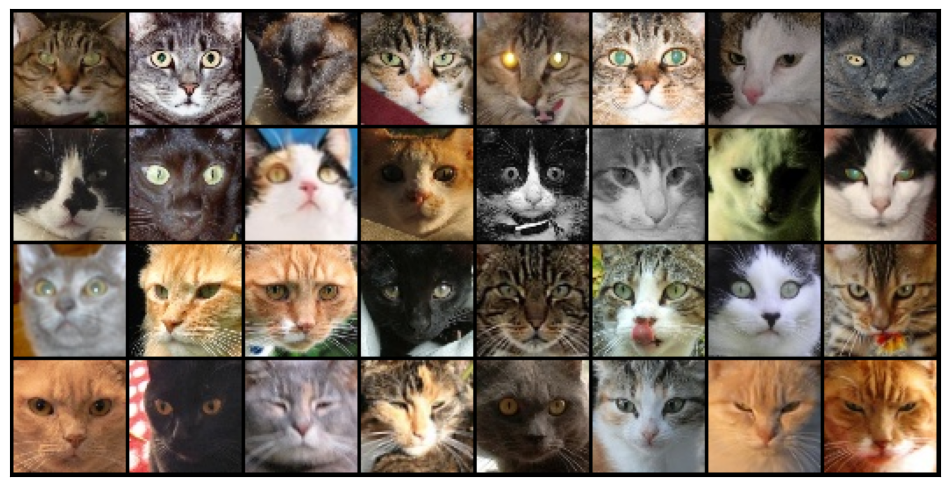

In [8]:
show_batch(train_loader)

## GAN

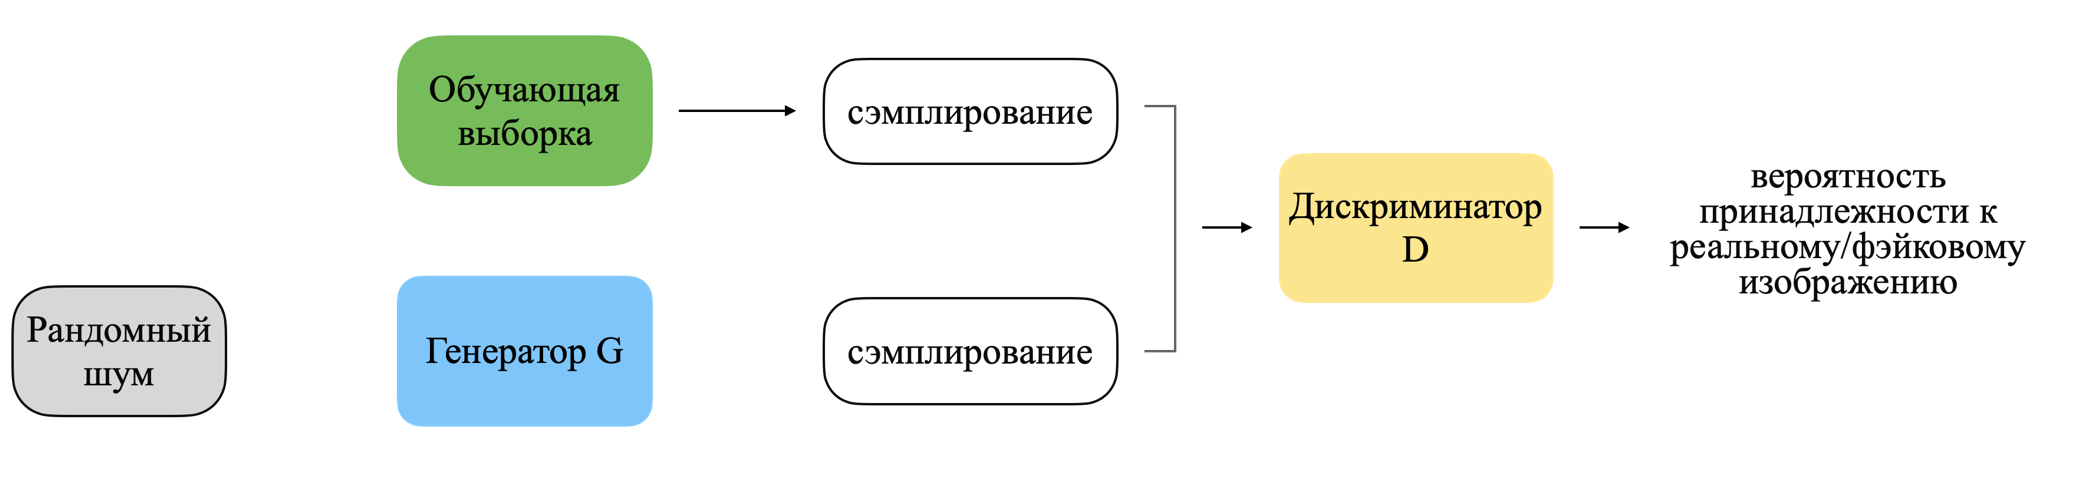

### Генератор

In [9]:
class Generator(nn.Module):

    def __init__(self, z_dim=128):
        super(Generator, self).__init__()

        self.image_shape = (3,64,64)
       
        self.model = nn.Sequential(
            nn.Linear(z_dim,128,bias=True),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Linear(128,256,bias=True),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Linear(256,512,bias=True),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Linear(512,1024,bias=True),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Linear(1024,2048,bias=True),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Linear(2048,int(np.prod(self.image_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *self.image_shape)
        return img

### Дискриминатор

In [10]:
class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()

        self.image_shape = (3,64,64)
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(self.image_shape)), 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024,512),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        output = self.model(img_flat)
        return output

## Обучение

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [12]:
epochs = 15
lr = 0.0002
batch_size = 64
loss = nn.BCELoss()

In [13]:
fixed_noise = torch.randn(16,128,device=device)

In [14]:
G = Generator().to(device)
D = Discriminator().to(device)

G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

In [15]:
def generate_images(fakes, image_folder):
    # Фунцкция для создания сетки и сохранения изображений
    image_grid = make_grid(
        fakes.to(device), padding=2, nrow=4, normalize=True
    )
    if not os.path.exists(image_folder):
        os.makedirs(image_folder)
    save_image(image_grid,'{}/img_{}.png'.format(image_folder, epoch))

In [16]:
losses_g = []
losses_d = []


for epoch in range(epochs):
    for idx, (imgs, _) in enumerate(train_loader):
        idx += 1

        # Обучаем дискриминатор
        # Real inputs - реальные картинки из Cats
        # Fake inputs - выход генератора
        # Real inputs должны быть классифицированы как 1, fake - 0
        real_inputs = imgs.to(device)
        real_outputs = D(real_inputs)
        real_label = torch.ones(real_inputs.shape[0], 1).to(device)

        noise = (torch.rand(real_inputs.shape[0], 128) - 0.5) / 0.5
        noise = noise.to(device)
        fake_inputs = G(noise)
        fake_outputs = D(fake_inputs)
        fake_label = torch.zeros(fake_inputs.shape[0], 1).to(device)

        outputs = torch.cat((real_outputs, fake_outputs), 0)
        targets = torch.cat((real_label, fake_label), 0)

        D_loss = loss(outputs, targets)
        D_optimizer.zero_grad()
        D_loss.backward()
        D_optimizer.step()

        # Обучаем генератор
        # Цель генератора - заставить дискриминатор верить, что все картинки класса 1
        noise = (torch.rand(real_inputs.shape[0], 128)-0.5)/0.5
        noise = noise.to(device)

        fake_inputs = G(noise)
        fake_outputs = D(fake_inputs)
        # Пытаемся обмануть дискриминатор
        fake_targets = torch.ones([fake_inputs.shape[0], 1]).to(device)
        G_loss = loss(fake_outputs, fake_targets)
        G_optimizer.zero_grad()
        G_loss.backward()
        G_optimizer.step()

        # Сохраняем лосс генератора и дискриминатора
        losses_g.append(G_loss)
        losses_d.append(D_loss)


        if idx % 100 == 0 or idx == len(train_loader):
            print('Epoch {} Iteration {}: discriminator_loss {:.3f} generator_loss {:.3f}'.format(epoch, idx, D_loss.item(), G_loss.item()))

        # Сохраним сгенерированные изображения
        with torch.no_grad():
            fakes = G(fixed_noise)
            image_folder = './generated_images'
            generate_images(fakes,image_folder)

    if (epoch+1) % 10 == 0:
        torch.save(G, 'Generator_epoch_{}.pth'.format(epoch))
        print('Model saved.')

Epoch 0 Iteration 100: discriminator_loss 0.507 generator_loss 0.569
Epoch 0 Iteration 124: discriminator_loss 0.232 generator_loss 1.298
Epoch 1 Iteration 100: discriminator_loss 0.169 generator_loss 2.016
Epoch 1 Iteration 124: discriminator_loss 0.188 generator_loss 3.017
Epoch 2 Iteration 100: discriminator_loss 0.398 generator_loss 2.312
Epoch 2 Iteration 124: discriminator_loss 0.520 generator_loss 1.411
Epoch 3 Iteration 100: discriminator_loss 0.318 generator_loss 2.664
Epoch 3 Iteration 124: discriminator_loss 0.218 generator_loss 0.251
Epoch 4 Iteration 100: discriminator_loss 0.437 generator_loss 1.887
Epoch 4 Iteration 124: discriminator_loss 0.289 generator_loss 2.661
Epoch 5 Iteration 100: discriminator_loss 0.327 generator_loss 1.756
Epoch 5 Iteration 124: discriminator_loss 0.168 generator_loss 3.082
Epoch 6 Iteration 100: discriminator_loss 0.552 generator_loss 2.411
Epoch 6 Iteration 124: discriminator_loss 0.320 generator_loss 1.974
Epoch 7 Iteration 100: discriminat

## Анализ результатов

In [17]:
from IPython.display import Image

Посмотрим на содержимое папки с образцами сгенерированныx изображений на каждой эпохе.

In [18]:
!ls ./generated_images

img_0.png   img_11.png	img_14.png  img_4.png  img_7.png
img_1.png   img_12.png	img_2.png   img_5.png  img_8.png
img_10.png  img_13.png	img_3.png   img_6.png  img_9.png


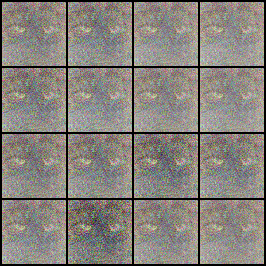

In [19]:
Image('./generated_images/img_0.png')

На первой эпохе ничего содержательного мы не видим, лишь смутно угадываются очертания мордашки.

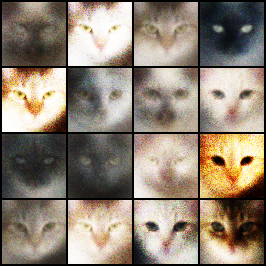

In [20]:
Image('./generated_images/img_9.png')

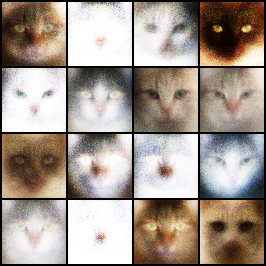

In [21]:
Image('./generated_images/img_14.png')

А здесь мы видим, что особенной разницы между изображениями сгененированными на 10 и 15 эпохах будто бы нет — повод посмотреть на loss-ы.

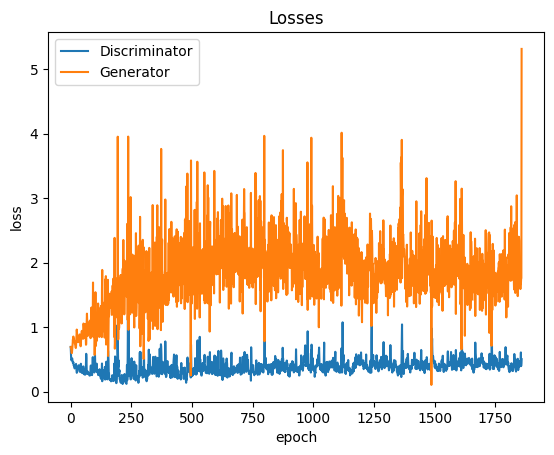

In [27]:
plt.plot([tnsr.cpu().detach().numpy() for tnsr in losses_d], '-')
plt.plot([tnsr.cpu().detach().numpy() for tnsr in losses_g], '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

Видим, как осцилирует loss генератора — признак того, что он не вполне сошелся. Иное мы наблюдаем в динамике loss-а дискриминатора.